In [15]:
!pip install numpy pandas librosa soundfile scikit-learn matplotlib seaborn tqdm joblib pydub




In [16]:
import os

DATA_DIR = r"D:\Ankush\Projects\ML\Infants Cry Sound\Dataset"   
classes = ["Hungry", "Tired", "Uncomfortable"]

for c in classes:
    folder = os.path.join(DATA_DIR, c)
    print(c, ":", len(os.listdir(folder)), "files")


Hungry : 31 files
Tired : 1 files
Uncomfortable : 31 files


### Preprocessing ###

In [17]:
import os
import numpy as np
from tqdm import tqdm
import librosa
from pydub import AudioSegment

# Dataset path & classes
DATA_DIR = r"D:\Ankush\Projects\ML\Infants Cry Sound\Dataset"  # change this
classes = ["Hungry", "Tired", "Uncomfortable"]

# Parameters
SR = 16000
CLIP_LEN = 4.0
N_MFCC = 40

# Function to preprocess audio
def preprocess_audio(path, sr=SR, clip_len=CLIP_LEN):
    ext = os.path.splitext(path)[1].lower()
    try:
        if ext in [".wav", ".mp3"]:
            y, _ = librosa.load(path, sr=sr, mono=True)
        elif ext == ".m4a":
            audio = AudioSegment.from_file(path)
            y = np.array(audio.get_array_of_samples()).astype(np.float32)
            y = y / (2**15)  # normalize to [-1,1]
        else:
            raise ValueError(f"Unsupported audio format: {ext}")

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=30)
        if len(y) == 0:
            y = np.zeros(int(sr*clip_len))
        # Normalize
        y = y / np.max(np.abs(y))
        # Pad or crop
        target_len = int(sr*clip_len)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]
        return y
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None


### Building a FEATURE MATRIX ###

In [18]:
#Extracting features

def extract_features(y, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])
    return feat

#Building a feature matrix

X, y = [], []

for label_idx, label in enumerate(classes):
    folder = os.path.join(DATA_DIR, label)
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}")
        continue

    files = [f for f in os.listdir(folder) if f.lower().endswith((".wav", ".m4a", ".mp3"))]
    print(f"{label}: {len(files)} audio file(s) found")

    for file in tqdm(files, desc=f"Processing {label}"):
        path = os.path.join(folder, file)
        audio = preprocess_audio(path)
        if audio is not None:
            feat = extract_features(audio)
            X.append(feat)
            y.append(label_idx)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print(" Labels shape:", y.shape)
print("Class distribution:", {classes[i]: sum(y==i) for i in range(len(classes))})


Hungry: 29 audio file(s) found


Processing Hungry: 100%|██████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 103.92it/s]


Tired: 1 audio file(s) found


Processing Tired: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


Uncomfortable: 30 audio file(s) found


Processing Uncomfortable: 100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.54it/s]

Feature matrix shape: (60, 80)
 Labels shape: (60,)
Class distribution: {'Hungry': 29, 'Tired': 1, 'Uncomfortable': 30}


### Creating new points for tired by oversampling ###

In [20]:
import numpy as np
from collections import Counter

# Dynamically find Tired label index
tired_label_idx = classes.index("Tired")
tired_idx = np.where(y == tired_label_idx)[0]

# Original Tired samples
X_tired = X[tired_idx]
y_tired = y[tired_idx]

# Number of synthetic samples needed
num_synthetic = 30

# Initialize lists
X_synthetic = []
y_synthetic = []

# Generate synthetic samples with small Gaussian noise
for _ in range(num_synthetic):
    sample_idx = np.random.choice(len(X_tired))
    new_sample = X_tired[sample_idx] + np.random.normal(0, 0.01, size=X.shape[1])
    X_synthetic.append(new_sample)
    y_synthetic.append(tired_label_idx)

# Convert to numpy arrays
X_synthetic = np.array(X_synthetic)
y_synthetic = np.array(y_synthetic)

# Append synthetic samples to the original dataset
X_balanced = np.vstack([X, X_synthetic])
y_balanced = np.hstack([y, y_synthetic])

# Check new class distribution
counter = Counter(y_balanced)
print("New class distribution:", {classes[i]: counter[i] for i in range(len(classes))})


New class distribution: {'Hungry': 29, 'Tired': 31, 'Uncomfortable': 30}



### Feature distribution


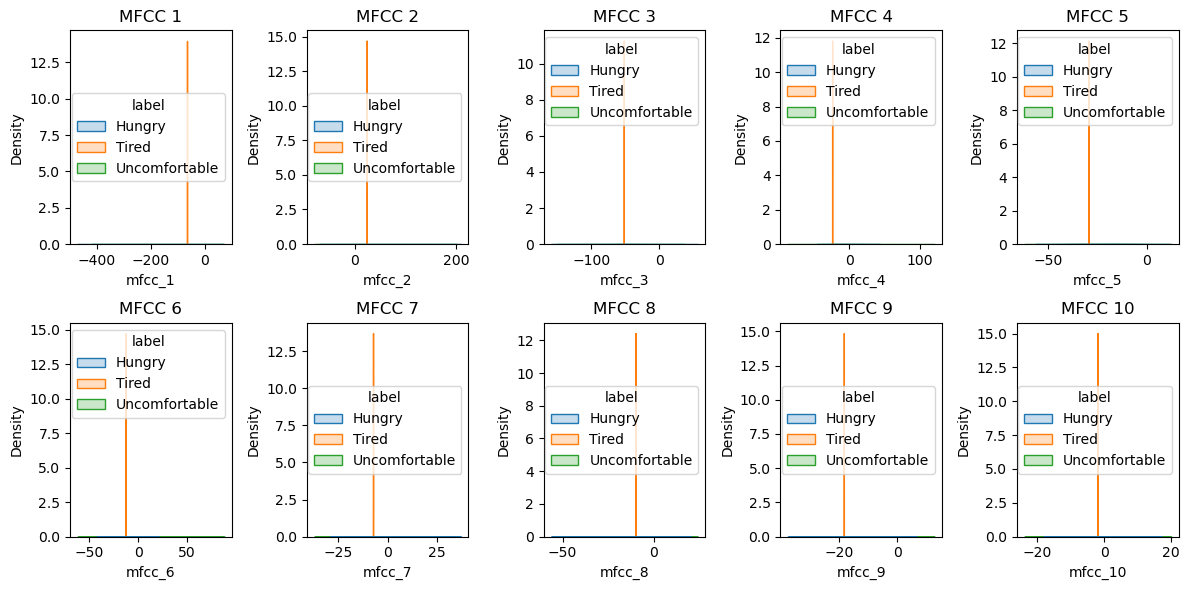

Mean and STD of first 10 features per class:
                   mfcc_1                mfcc_2                mfcc_3  \
                     mean        std       mean        std       mean   
label                                                                   
Hungry        -176.528461  86.100765  53.763959  44.933228 -50.449906   
Tired          -68.199466   0.009096  23.623194   0.011011 -52.187788   
Uncomfortable -176.989471  74.409397  50.228878  45.806259 -60.081870   

                             mfcc_4                mfcc_5             \
                     std       mean        std       mean        std   
label                                                                  
Hungry         29.716803  -4.148013  14.927885 -22.378011  10.703230   
Tired           0.011869 -23.910350   0.011464 -29.504026   0.010655   
Uncomfortable  29.713870   8.972542  35.624224 -21.375197  11.032307   

                  mfcc_6               mfcc_7                mfcc_8  \
            

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert to DataFrame for easier plotting
n_features = X_balanced.shape[1]
feature_names = [f"mfcc_{i+1}" for i in range(n_features)]
df_features = pd.DataFrame(X_balanced, columns=feature_names)
df_features['label'] = [classes[i] for i in y_balanced]

# -----------------------------
# Feature distribution for first 10 MFCC features
# -----------------------------
plt.figure(figsize=(12,6))
for i in range(10):  # plot first 10 MFCCs
    plt.subplot(2,5,i+1)
    sns.kdeplot(data=df_features, x=f"mfcc_{i+1}", hue='label', fill=True)
    plt.title(f"MFCC {i+1}")
plt.tight_layout()
plt.show()

# -----------------------------
# Mean ± STD per feature per class
# -----------------------------
feature_stats = df_features.groupby('label').agg(['mean','std'])
print("Mean and STD of first 10 features per class:")
print(feature_stats.iloc[:,:20]) 


### Feature heatmap

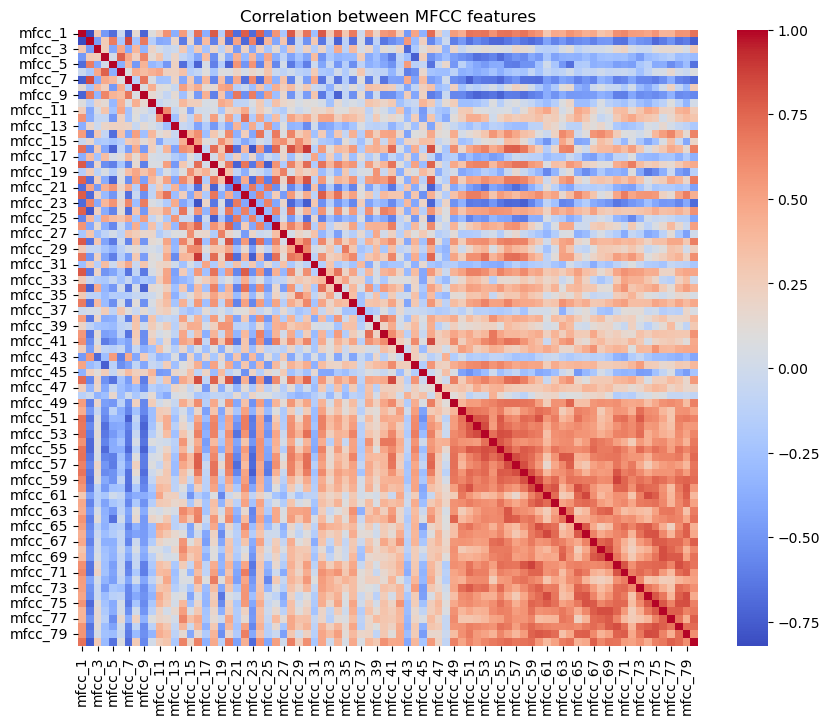

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df_features.iloc[:,:n_features].corr(), cmap="coolwarm")
plt.title("Correlation between MFCC features")
plt.show()


### PCA 2D visualization

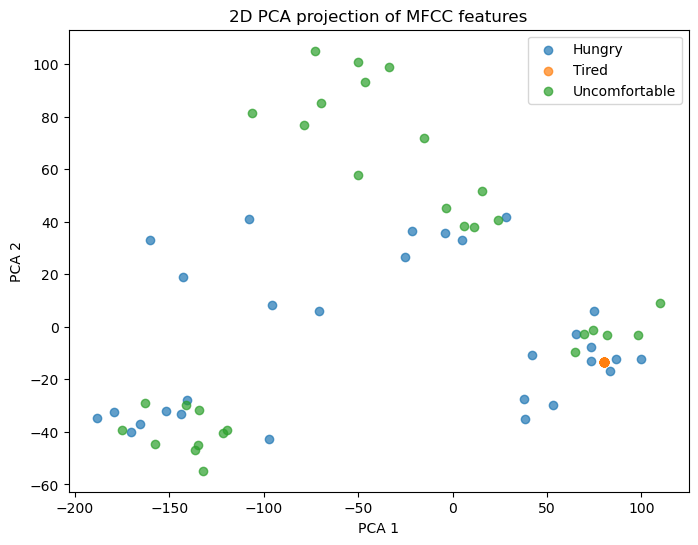

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_balanced)

plt.figure(figsize=(8,6))
for i, label in enumerate(classes):
    plt.scatter(X_pca[y_balanced==i,0], X_pca[y_balanced==i,1], label=label, alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D PCA projection of MFCC features')
plt.legend()
plt.show()

### Pairwise scatterplot

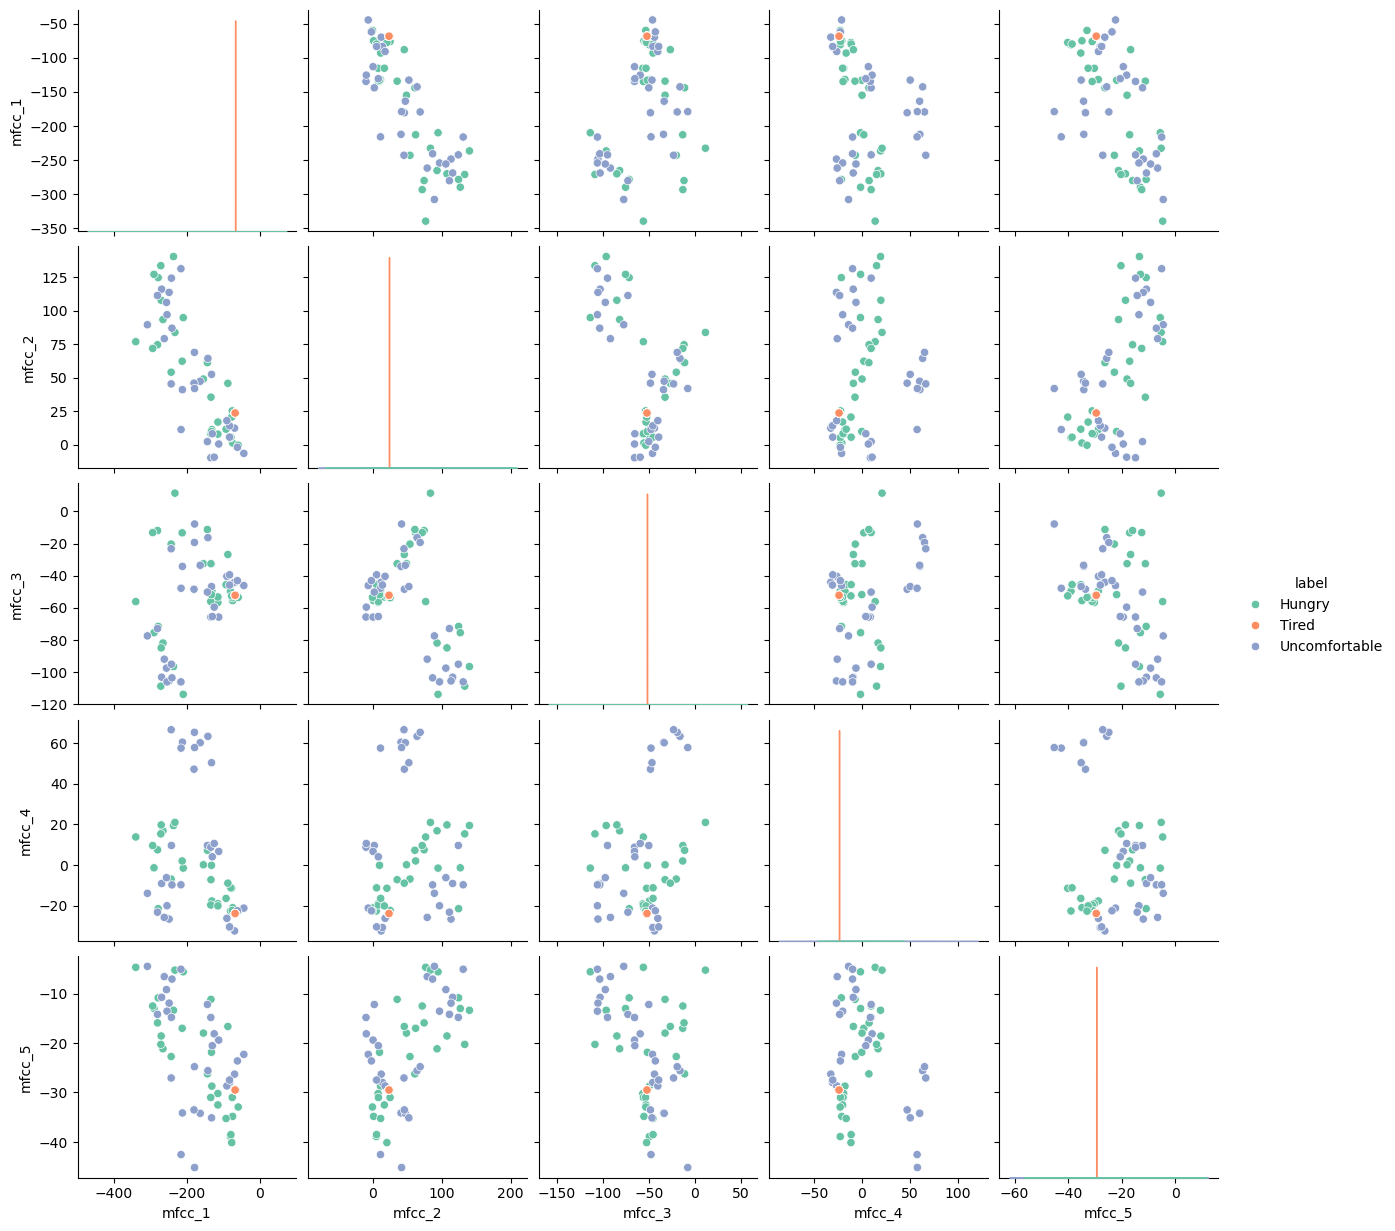

In [10]:
sns.pairplot(df_features.iloc[:, :5].join(df_features['label']), hue='label', palette='Set2')
plt.show()

### Finding best suitable K for K-NN using K fold cross validation

Best K value: 2
Best cross-validated accuracy: 0.8333


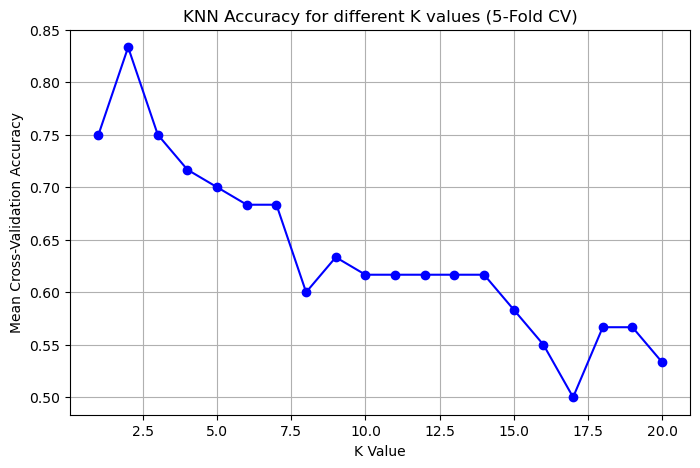

In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Define range of K values
k_values = range(1, 21)  # you can extend to 30 if needed
cv_scores = []

# Step 3: Perform K-Fold Cross Validation for each K
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=kf, scoring='accuracy')
    cv_scores.append(scores.mean())

# Step 4: Find the best K
best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"Best K value: {best_k}")
print(f"Best cross-validated accuracy: {best_score:.4f}")

# Step 5: Plot K vs Accuracy
plt.figure(figsize=(8,5))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy for different K values (5-Fold CV)')
plt.xlabel('K Value')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)
plt.show()


### Training the model using best K

✅ Model Accuracy: 0.6667

📄 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           2       0.83      0.62      0.71         8

    accuracy                           0.67        12
   macro avg       0.67      0.69      0.66        12
weighted avg       0.72      0.67      0.68        12



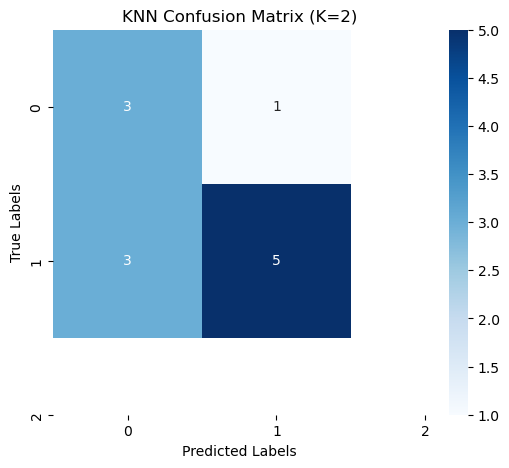

In [22]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 1️⃣ Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# 2️⃣ Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3️⃣ Train KNN with best_k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# 4️⃣ Make predictions
y_pred = knn.predict(X_test_scaled)

# 5️⃣ Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")
print("\n📄 Classification Report:\n")
print(classification_report(y_test, y_pred))

# 6️⃣ Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f"KNN Confusion Matrix (K={best_k})")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
